# 【ベイズ統計モデリング入門】NumPyroで回帰モデルをつくる
https://cpp-learning.com/numpyro/

In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
 
import jax.numpy as jnp
from jax import random, vmap, grad, jit, lax
 
import numpyro
from numpyro import plate, sample
from numpyro.infer import MCMC, NUTS, Predictive
import numpyro.distributions as dist

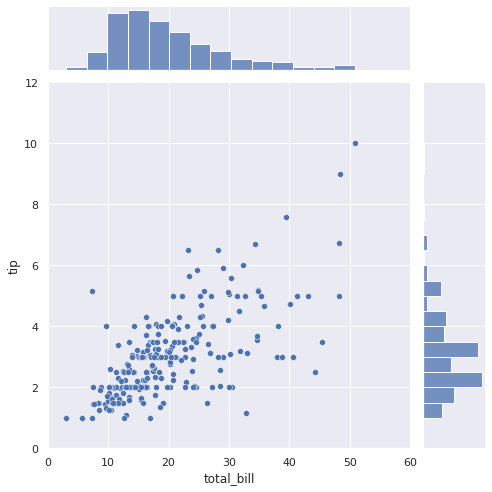

In [2]:
# チップのデータセット
df = sns.load_dataset("tips")
 
# 会計総額とチップのデータを可視化
sns.set(style="darkgrid")
sns.jointplot(x="total_bill", y="tip", data=df,
              kind="scatter",
              xlim=(0, 60), ylim=(0, 12),
              color="b",
              height=7);

In [3]:
Y = df['tip'].values          # 目的変数：Y = [y0, y1, y2, ... yi]
X = df['total_bill'].values   # 説明変数：X = [x0, x1, x2, ... xi]

# ベイズ統計モデリング -線形回帰モデル-

In [4]:
 # 線形回帰モデルの設計
def model(X, Y=None):
    pm_a = numpyro.sample('pm_a', dist.Normal(0.0, 10.0))
    pm_b = numpyro.sample('pm_b', dist.Normal(0.0, 10.0))
    
    mu = pm_a * X + pm_b
    sigma = 1.0

    pm_Y = numpyro.sample('pm_Y', dist.Normal(mu, sigma), obs=Y)

    return pm_Y 

#### ここでは a を傾き、b を切片と呼ぶことにし、y = ax + b で”あてはまり”の良い予測ができると考えました。

#### また傾き:a、切片:b、予測値:y が正規分布に従うと考えました。

In [5]:
# Run MCMC
kernel = NUTS(model)
mcmc = MCMC(kernel, num_warmup=1000, num_samples=2000)
mcmc.run(rng_key=random.PRNGKey(0), X=X, Y=Y)

# print MCMC summary（推定パラメータの基本統計量）
mcmc.print_summary()

sample: 100%|███████████████████████████████████████| 3000/3000 [00:09<00:00, 330.76it/s, 1 steps of size 2.81e-01. acc. prob=0.93]



                mean       std    median      5.0%     95.0%     n_eff     r_hat
      pm_a      0.11      0.01      0.11      0.09      0.12    373.93      1.01
      pm_b      0.90      0.16      0.90      0.65      1.16    382.57      1.01

Number of divergences: 0


#### MCMCで算出された推定パラメータ（pm_a、pm_b）は以下のコードで取得できます。

In [6]:
# get param (num_samples=2000)
mcmc_samples = mcmc.get_samples()
pm_a = mcmc_samples["pm_a"]
pm_b = mcmc_samples["pm_b"]

print("mcmc_samples:", mcmc_samples)
print("pm_a:", pm_a)
print("pm_b:", pm_b)

mcmc_samples: {'pm_a': DeviceArray([0.10222346, 0.10575496, 0.10643967, ..., 0.09297126,
             0.09851319, 0.09851319], dtype=float32), 'pm_b': DeviceArray([1.0172218, 0.9356567, 0.904531 , ..., 1.0267701, 1.1342174,
             1.1342174], dtype=float32)}
pm_a: [0.10222346 0.10575496 0.10643967 ... 0.09297126 0.09851319 0.09851319]
pm_b: [1.0172218 0.9356567 0.904531  ... 1.0267701 1.1342174 1.1342174]


#### pm_a および pm_b は 事後分布なので、以下のコードで分布を可視化できます。

/opt/conda/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/opt/conda/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


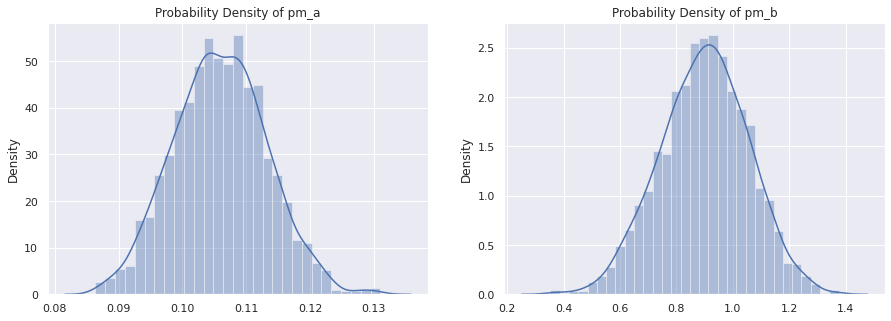

In [7]:
# 可視化
sns.set(style="darkgrid")
plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
sns.distplot(pm_a)
plt.title("Probability Density of pm_a")

plt.subplot(1, 2, 2)
sns.distplot(pm_b)
plt.title("Probability Density of pm_b")
plt.show()

#### X＝0, 1, …, 49, 50 のときの Y を予測

In [8]:
X_range = jnp.linspace(0, 50, 50)

predictive = Predictive(model, mcmc_samples)
predict_samples = predictive(random.PRNGKey(0), X=X_range, Y=None)
# print(predict_samples)

pm_Y = predict_samples['pm_Y']
print(pm_Y)

[[ 2.1746728   1.892698    0.36444163 ...  4.3245716   5.767526
   4.7748313 ]
 [ 1.8419392  -0.03850996  0.56691325 ...  7.1731596   4.653446
   7.188322  ]
 [ 0.9015761   0.41268575  0.9201288  ...  6.3077655   5.7549143
   5.023136  ]
 ...
 [ 1.0497273   2.3121965   0.12025678 ...  4.671981    5.0892024
   5.964785  ]
 [ 2.0053964   1.1490194   2.0747068  ...  5.90635     4.986282
   6.432155  ]
 [-0.8682033   0.90055585  2.0581765  ...  6.902018    5.49933
   5.538338  ]]


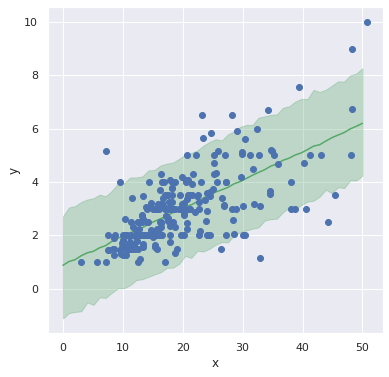

In [9]:
mean_Y = pm_Y.mean(axis=0)
y_low, y_high = jnp.percentile(pm_Y, [2.5, 97.5], axis=0)

# 可視化
fig = plt.figure(figsize=(6.0, 6.0))
plt.plot(X_range, mean_Y, '-', color='g')
plt.fill_between(X_range, y_low, y_high, color='g', alpha=0.3)
plt.plot(X, Y, "o")
plt.xlabel('x'), plt.ylabel('y')
plt.show()

#### 推定パラメータ:pm_a, pm_b の全サンプル（今回は2,000サンプル）で推論

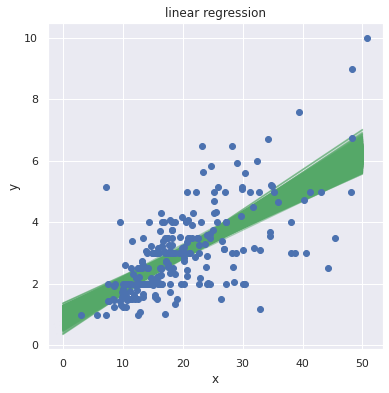

In [10]:
N = len(pm_a)
# X_range = jnp.linspace(0, 50, 50)

# 予測結果の可視化
fig = plt.figure(figsize=(6.0, 6.0))
for i in range(N):
    pm_y = [pm_a[i] * x + pm_b[i] for x in X_range]
    plt.plot(X_range, pm_y, 'g-', alpha=0.5)

# データセットの可視化
plt.plot(X, Y, "o")
plt.xlabel('x'), plt.ylabel('y')
plt.title('linear regression')
plt.show()

#### 最後に pm_a, pm_b の平均値を採用して、線形回帰モデルをつくります（扱いやすいように関数化しておきます）

#### こうすることで『任意の x に対する予測値 y を一意に決めるモデルを生成』できるため、システムなどに組み込み易くなります

In [11]:
def my_model(mcmc_samples, X):
    '''線形回帰モデル'''
    mcmc_samples = mcmc.get_samples()
    pm_a = mcmc_samples["pm_a"]
    pm_b = mcmc_samples["pm_b"]

    # 平均値
    mu_a = jnp.mean(pm_a, axis=0)
    mu_b = jnp.mean(pm_b, axis=0)
    print("mu_a=", mu_a)
    print("mu_b=", mu_b)

    # 線形回帰モデル
    Y_hat =  mu_a * X + mu_b

    return Y_hat

mu_a= 0.1059471
mu_b= 0.8990243


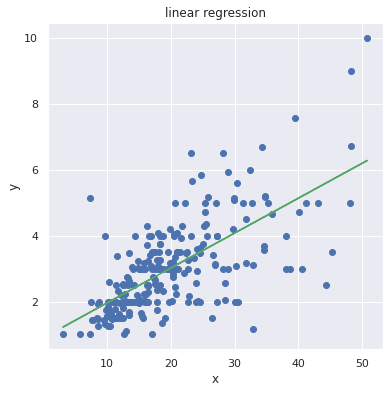

In [12]:
Y_hat = my_model(mcmc_samples, X)
 
# 可視化
fig = plt.figure(figsize=(6.0, 6.0))
plt.plot(X, Y, "o")
plt.plot(X, Y_hat, "g-")
plt.xlabel('x'), plt.ylabel('y')
plt.title('linear regression')
plt.show()

# ベイズ統計モデリング -ポアソン回帰モデル-

#### y = exp(a*x + b) を採用し、かつポアソン分布に従う

In [13]:
# ポアソン回帰モデルの設計
def model(X, Y=None):
    pm_a = numpyro.sample('pm_a', dist.Normal(0.0, 10.0))
    pm_b = numpyro.sample('pm_b', dist.Normal(0.0, 10.0))
    
    theta = pm_a * X + pm_b
    mu = jnp.exp(theta)
    
    numpyro.sample('pm_Y', dist.Poisson(mu), obs=Y)

In [14]:
# Run MCMC
kernel = NUTS(model)
# mcmc = MCMC(kernel, num_warmup=1000, num_samples=2000, num_chains=4)
mcmc = MCMC(kernel, num_warmup=1000, num_samples=2000)
mcmc.run(rng_key=random.PRNGKey(0), X=X, Y=Y)

# print MCMC summary（事後分布の基本統計量を確認）
mcmc.print_summary()

sample: 100%|███████████████████████████████████████| 3000/3000 [00:08<00:00, 361.21it/s, 1 steps of size 2.45e-01. acc. prob=0.92]



                mean       std    median      5.0%     95.0%     n_eff     r_hat
      pm_a      0.03      0.00      0.03      0.02      0.04    419.80      1.01
      pm_b      0.45      0.09      0.45      0.30      0.61    405.19      1.01

Number of divergences: 0


/opt/conda/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/opt/conda/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


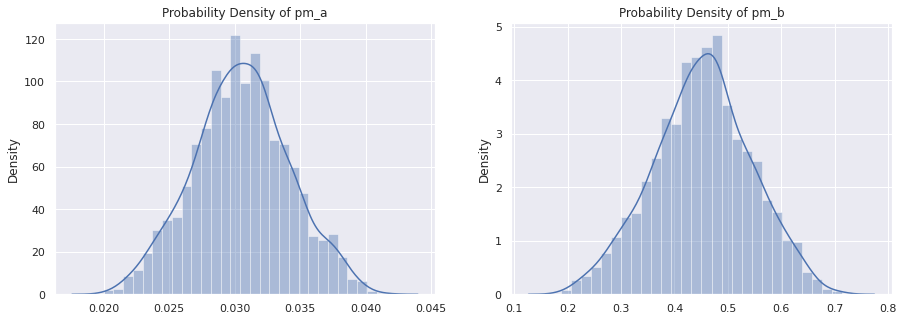

In [15]:
# get param (num_samples=2000)
mcmc_samples = mcmc.get_samples()
pm_a = mcmc_samples["pm_a"]
pm_b = mcmc_samples["pm_b"]

# 可視化
sns.set(style="darkgrid")
plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
sns.distplot(pm_a)
plt.title("Probability Density of pm_a")

plt.subplot(1, 2, 2)
sns.distplot(pm_b)
plt.title("Probability Density of pm_b")
plt.show()

#### X＝0, 1, …, 49, 50 のときの Y を予測

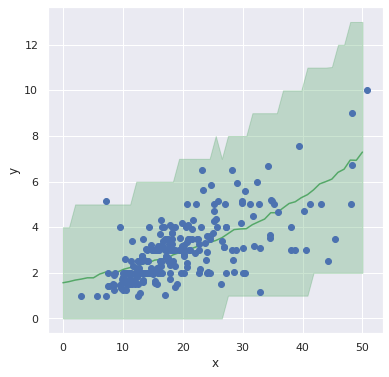

In [16]:
X_range = jnp.linspace(0, 50, 50)

predictive = Predictive(model, mcmc_samples)
predict_samples = predictive(random.PRNGKey(0), X=X_range, Y=None)
# print(predict_samples)

pm_Y = predict_samples['pm_Y']
# print(pm_Y)

mean_Y = pm_Y.mean(axis=0)
y_low, y_high = jnp.percentile(pm_Y, [2.5, 97.5], axis=0)

# 可視化
fig = plt.figure(figsize=(6.0, 6.0))
plt.plot(X_range, mean_Y, '-', color='g')
plt.fill_between(X_range, y_low, y_high, color='g', alpha=0.3)
plt.plot(X, Y, "o")
plt.xlabel('x'), plt.ylabel('y')
plt.show()

#### 推定パラメータ:pm_a, pm_b の全サンプル（今回は2,000サンプル）で推論

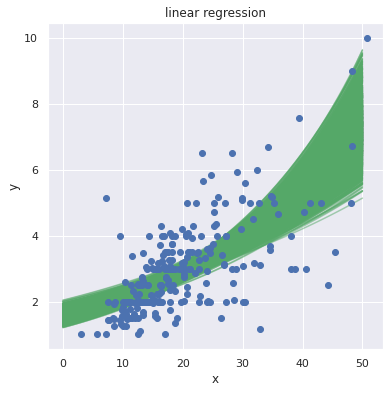

In [17]:
N = len(pm_a)
# X_range = jnp.linspace(0, 50, 50)

# 予測結果の可視化
fig = plt.figure(figsize=(6.0, 6.0))
for i in range(N):
    pm_y = [jnp.exp(pm_a[i] * x + pm_b[i]) for x in X_range]
    plt.plot(X_range, pm_y, 'g-', alpha=0.5)

# データセットの可視化
# x:会計総額（total_bill）, y:チップ額(tip)
plt.plot(X, Y, "o")
plt.xlabel('x'), plt.ylabel('y')
plt.title('linear regression')
plt.show()

xの値が大きいほど、yの予測候補の範囲が広いことが分かります。この予測範囲の広さを「予測結果の自信の無さ」という解釈ができそうです。

例えば、会計総額が小さい場合、チップ額（予測値）の”ばらつき”が小さいです。これを直観的に解釈すると「会計総額が小さい場合、ある程度”決まりきったチップ額”になる」といえそうです。

一方で会計総額が大きくなるにつれて、チップ額（予測値）の”ばらつき”も大きくなります。これは「会計総額が大きい客の中に、気前の良い客が含まれており、線形増加ではないチップ額を支払う場合もある」といえそうです。

ただし、会計総額が大きいときのサンプルが少ないので、モデルは自信のある予測ができない…などの解釈ができそうです。

#### pm_a, pm_bの平均値を採用して、ポアソン回帰モデル（の関数）をつくり、結果の可視化

mu_a= 0.030502813
mu_b= 0.4517227


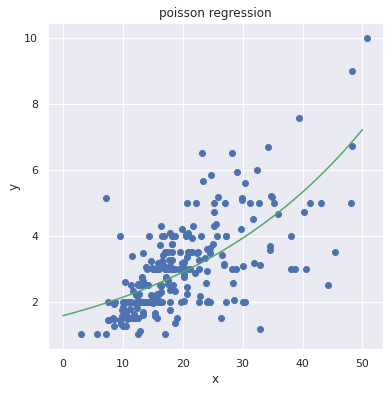

In [18]:
def my_model(mcmc_samples, X):
    '''ポアソン回帰モデル'''
    mcmc_samples = mcmc.get_samples()
    pm_a = mcmc_samples["pm_a"]
    pm_b = mcmc_samples["pm_b"]

    # 平均値
    mu_a = jnp.mean(pm_a, axis=0)
    mu_b = jnp.mean(pm_b, axis=0)
    print("mu_a=", mu_a)
    print("mu_b=", mu_b)

    # ポアソン回帰モデル
    Y_hat =  jnp.exp(mu_a * X + mu_b)

    return Y_hat

# 予測値
Y_hat = my_model(mcmc_samples, X_range)

# 可視化
fig = plt.figure(figsize=(6.0, 6.0))
plt.plot(X, Y, "o")
plt.plot(X_range, Y_hat, "g-")
plt.xlabel('x'), plt.ylabel('y')
plt.title('poisson regression')
plt.show()